### <span style="color:cyan"><i>Data Cleaning</i></span>

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/SumanGouda/Scikit-Learn-/refs/heads/main/PROJECT/HEART%20DISEASE/heart_disease_uci.csv')

In [6]:
df.columns

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')

In [5]:
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
categorical_cols_less_missing = ['fbs', 'restecg', 'exang']
categorical_cols_most_missing = ['thal', 'slope']
categorical_cols_mcar = ['restecg', 'exang']

numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']
numerical_cols_mcar = ['trestbps', 'chol', 'thalch', 'oldpeak']
not_zero_cols = ['chol', 'trestbps']


In [12]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['chol'], y=df['num'], mode='markers'))
fig.update_layout(title='Scatter Plot of age vs num', xaxis_title='age', yaxis_title='num')
fig.show()

In [151]:
X = df[categorical_cols + numerical_cols]
y = df['num']

In [152]:
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin

class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # Does nothing during fitting
    
    def transform(self, X):
        return np.log1p(X)  # Applies log(1 + x) to each value

class ZeroToNanTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns  # List of columns to process (e.g., ['chol', 'ca'])
    
    def fit(self, X, y=None):
        return self  # No fitting required
    
    def transform(self, X):
        X = X.copy()
        if self.columns:
            for col in self.columns:
                X[col] = X[col].replace(0, np.nan)  # Replace 0 with NaN
        return X

class RandomCategoryImputer(TransformerMixin, BaseEstimator):
    def __init__(self, columns=None, random_state=42):
        self.columns = columns
        self.random_state = random_state
        
    def fit(self, X, y=None):
        return self  # Nothing to fit
        
    def transform(self, X):
        X = X.copy()
        columns = self.columns if self.columns is not None else X.columns
        for col in columns:
            non_null = X[col].dropna()
            if len(non_null) == 0:
                continue
            X.loc[X[col].isnull(), col] = non_null.sample(
                n=X[col].isnull().sum(),
                replace=True,
                random_state=self.random_state
            ).values
        return X


In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.loc[:, categorical_cols + numerical_cols]

In [188]:
# Cleaning Categorical Data
trf1 = RandomCategoryImputer(
    columns=categorical_cols_less_missing 
)
# Cleaning those cols where zero values are imposible 
trf2 = ZeroToNanTransformer(
    columns = not_zero_cols
)
# Applying column transformer for categorical columns 
trf3 = ColumnTransformer([
    ('cat', SimpleImputer(strategy='most_frequent'), categorical_cols_mcar),  
    ('cat_most_missing', SimpleImputer(strategy='most_frequent', add_indicator=True), categorical_cols_most_missing)
], remainder='passthrough')

# Step 4: Ordinal encode to selected columns
trf4 = ColumnTransformer([
    ('encode', OrdinalEncoder(categories=[
        ['flat', 'upsloping', 'downsloping'],                                  # slope
        ['asymptomatic', 'non-anginal', 'atypical angina', 'typical angina']   # chest pain type
    ]), [3, 7])
], remainder='passthrough')

# Step 5: One Hot Encoding to nominal columns
trf5 = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', sparse_output=False), [2, 4, 7]),
    ('bool_to_int', FunctionTransformer(lambda x: x.astype(int)), [3, 5, 6, 8])
], remainder='passthrough')

# Step 6: Applying MinMax Scaler to all the categorical cols and Standard sclaer to numerical cols
trf6 = ColumnTransformer([
    ('minmax', MinMaxScaler(), [15]),     
    ('std', StandardScaler(), list(range(11, 15)))     
], remainder='passthrough')
# Using KNN imputer to fill the missing values 
trf7 = ColumnTransformer([
    ('knn_imputer',KNNImputer(n_neighbors=3, weights='distance'), list(range(0, 5)))
], remainder='passthrough')



In [189]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
    ('trf3', trf3),
    ('trf4', trf4),
    ('trf5', trf5),
    ('trf6', trf6),
    ('trf7', trf7),
    ('model', LinearRegression())
])
# output = pipe.fit(X_train)
# transformed_X = output.transform(X_train)
# transformed_X

# Fit the pipeline
pipe.fit(X_train, y_train)

# Predict
y_pred = pipe.predict(X_test)

#print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")


R2 Score: 0.3824


In [179]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipe, X, y, cv=5)
print(scores.mean())


-0.13286590043729155


<Axes: xlabel='trestbps', ylabel='Density'>

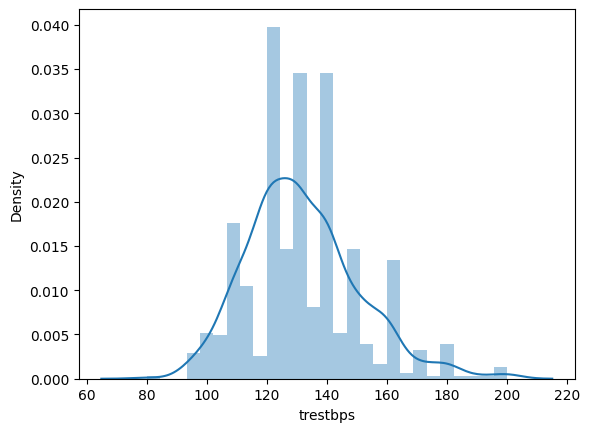

In [108]:
sns.distplot(X_train[X_train['trestbps'] != 0]['trestbps'], label='Before imputation')

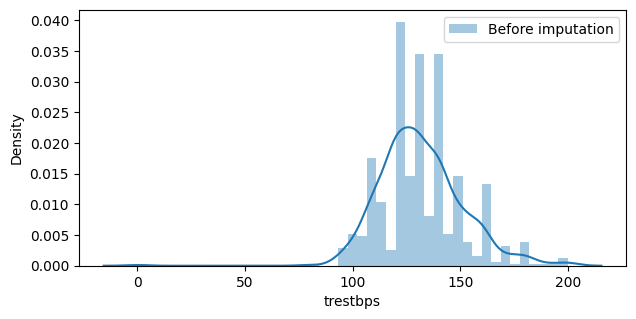

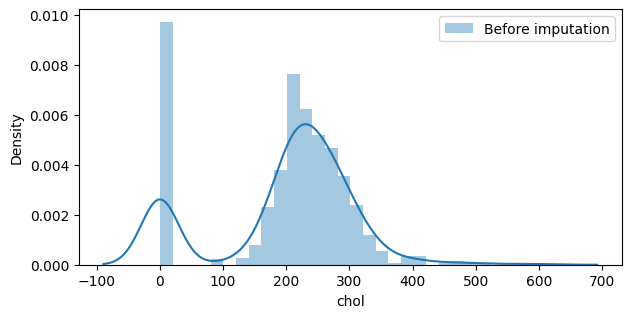

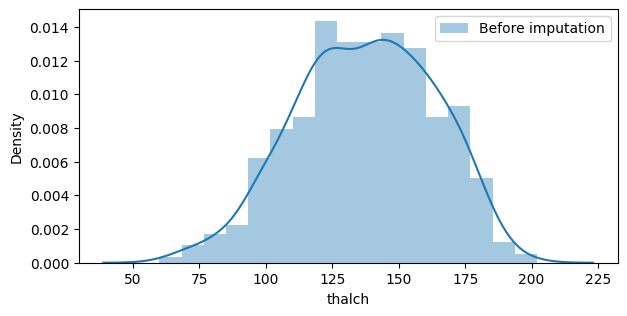

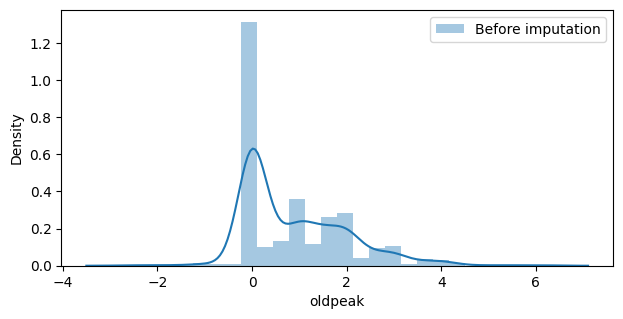

In [78]:
numerical_cols_mcar = ['trestbps', 'chol', 'thalch', 'oldpeak']
    
import seaborn as sns
for cols in numerical_cols_mcar:


    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    sns.distplot(X_train[cols], label='Before imputation')
    # sns.distplot(output['cat__exang'], label='After imputation')
    # plt.title('Exang Distribution')

    # plt.subplot(2, 2, 2)
    # sns.distplot(X_train['restecg'].value_counts(), label='Before imputation')
    # sns.distplot(output['cat__restecg'].value_counts(), label='After imputation')
    # plt.title('Restecg Distribution')

    # plt.subplot(2, 2, 3)
    # sns.distplot(X_train['thal'].value_counts(), label='Before imputation')
    # sns.distplot(output['remainder__thal'].value_counts(), label='After imputation')
    # plt.title('Thal Distribution')

    plt.tight_layout()
    plt.legend()
plt.show()

In [107]:
is_zero = X_train[X_train['chol'] == 0].shape[0]
total = X_train['chol'].dropna().shape[0]
percentage = (is_zero / total) * 100
percentage

19.549929676511955

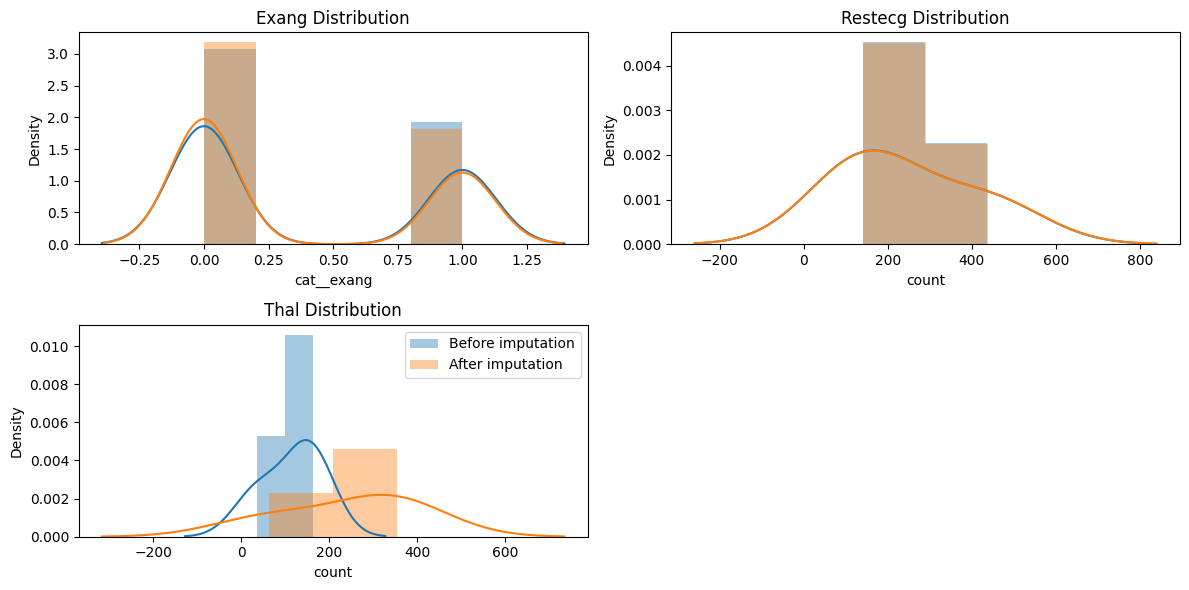

In [203]:
import seaborn as sns

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.distplot(X_train['exang'], label='Before imputation')
sns.distplot(output['cat__exang'], label='After imputation')
plt.title('Exang Distribution')

plt.subplot(2, 2, 2)
sns.distplot(X_train['restecg'].value_counts(), label='Before imputation')
sns.distplot(output['cat__restecg'].value_counts(), label='After imputation')
plt.title('Restecg Distribution')

plt.subplot(2, 2, 3)
sns.distplot(X_train['thal'].value_counts(), label='Before imputation')
sns.distplot(output['remainder__thal'].value_counts(), label='After imputation')
plt.title('Thal Distribution')

plt.tight_layout()
plt.legend()
plt.show()

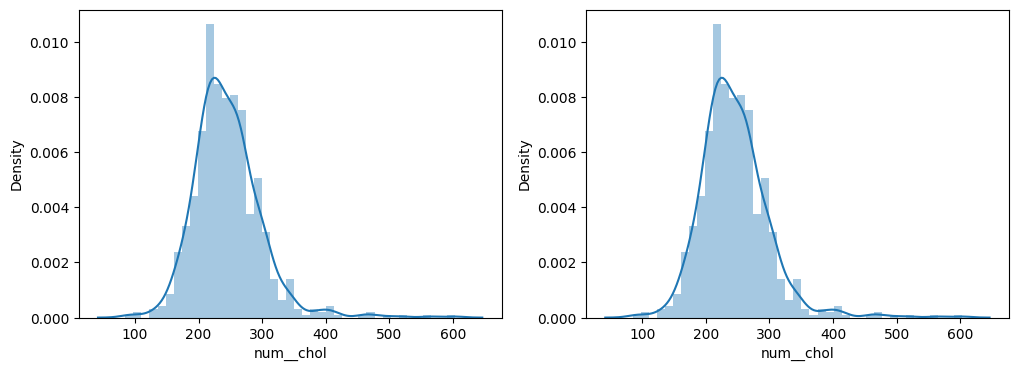

In [80]:
import seaborn as sns 
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.distplot(X_step2['num__chol'])
plt.subplot(1, 2, 2)
sns.distplot(X_step3['num__chol'])

plt.show()

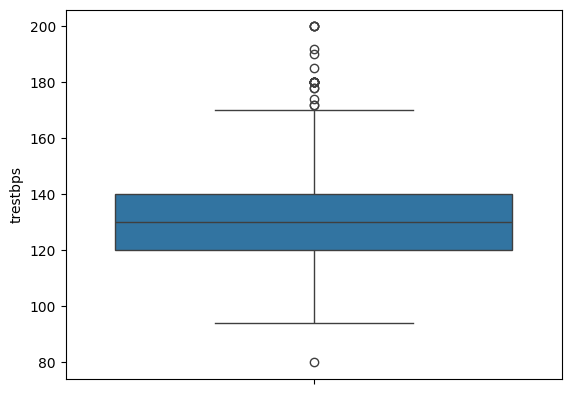

In [39]:
sns.boxplot(X_train['trestbps'])
plt.show()